   #  **Moncler Bayesian**
   
*** 

## ~ Spring ~

People working in fashion, financial analysts, and data scientists have a lot in common. They are explaining the momentum of each season with sophisticated words. Trends are forecasted with beautiful models. Yet, the most refined visions or the seductive models are missing the core element, “Simplicity”.

In fashion, it would be to craft a delicate garment that everyone is talking about but nobody buys. In finance, it would be to create a superb DCF model that crashes in front of your managing director. In data science, it would be to create a complex Deep Learning model that replies to the wrong question. 

In this research notebook, we will look at three methodology to forecast sales of the Italian brand **Moncler**:
- **Naive machine learning approach with OLS (ordinary least square)**
- **Facebook’s Prophet tool designed for time series forecast**
- **Probabilistic programming with a Bayesian approach**

Financial forecasts are often based on assumptions. For example, the terminal value in a DCF model is based on a formula of **“perpetual”** growth rate (falsely assuming that cash-flows of the company will growth at a constant rate of 5 years). Our subject, the luxury puffer jacket maker Moncler S.p.A is growing at an extremely fast pace. Marketing strategy entitled **“Moncler Genius”** seems to be very effective. Last December, the Italian company even acquired their smaller rival **Stone Island**, an Italian high-end outerwear brand for 1.15 billion euros. Let's try to forecast revenues with only few data points, but first.

### - *What’s Moncler Genius?*
In the past, Moncler used to show separately their collections according to the regular calendar of Paris and Milan with collections in Spring-Summer and Autumn-Winter. **“Moncler Gamme Bleu”** by *Thom Browne*, **“Moncler Gamme Rouge”** by *Giambiattista Valli*, and even a special collection **"Moncler O"** by *Virgil Abloh*.

From 2019, the Italian brand pivoted to a new business model entitled **“Moncler Genius”** including 8 popular artistic directors of different styles and nationalities. Those fashion designers are producing 8 “Moncler Genius” collections each year unveiled at the same time at a huge during the Milan Fashion Week. However, Genius collections are launched in-store and online on a monthly basis and designers are changing on a yearly basis.

In [1]:
import os
import sys
import datetime as dt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import scipy.stats as st
import cufflinks as cf
import yahoo_fin.stock_info as si

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
moncler_df = pdr.DataReader('MONC.MI', data_source='yahoo',start='2017-01-01',end='2020-12-31')

In [3]:
df=cf.datagen.ohlcv() 
qf=cf.QuantFig(moncler_df,kind='candlestick',title='Moncler S.p.A, (MONC.MI) in EUR',legend='top', name='GS',
               up_color='#006400',down_color='#8B0000') 
qf.add_bollinger_bands(colors=['magenta','dimgray']) 
qf.add_volume() 
qf.iplot()

### - *Financial results by year*

As March 2nd 2021:

-	Stock price is at **52.5 EUR** (historical record high)
-	Market Cap is at **13.28B**, EPS at **1.01** and PE Ratio at **51.92**
-	Moncler S.p.A shows **good resilience in 2020** during the spread of SARS-Cov2

Let's have a look at the income statement to better understand the company...

In [4]:
income = si.get_income_statement('MONC.MI', yearly = True)
mon_income = income.transpose()

In [5]:
mon_income.sort_index(inplace=True)

In [6]:
mon_income['date'] = mon_income.index.strftime('%Y-%m-%d')

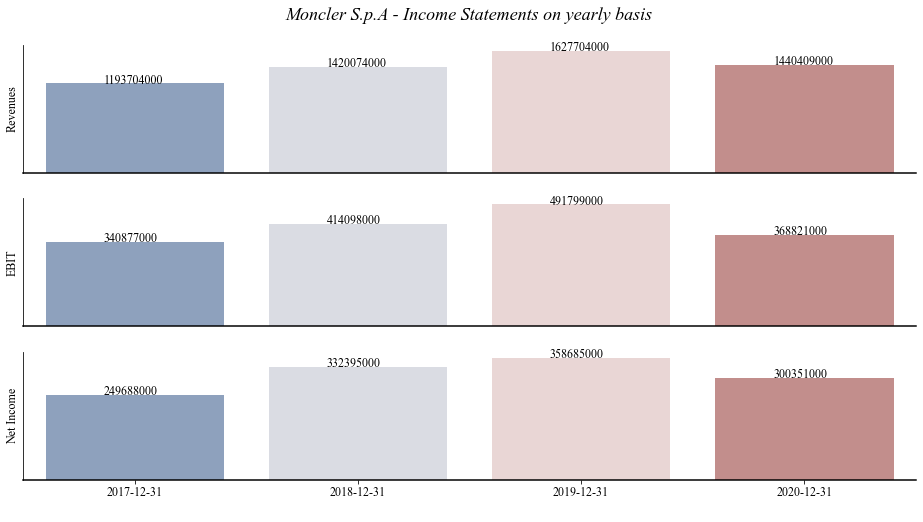

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 8))
sns.barplot(mon_income['date'], mon_income['totalRevenue'], palette="vlag",ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
for i, v in enumerate(mon_income['totalRevenue']):
    ax1.text(i - 0.14, v,str(v))
    
ax1.set_ylabel("Revenues")
ax1.xaxis.set_visible(False)
ax1.set_title("Moncler S.p.A - Income Statements on yearly basis",fontsize=18, 
              family='Times New Roman', style='italic', pad='25')

sns.barplot(mon_income['date'], mon_income['ebit'],palette="vlag",ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("EBIT")
ax2.xaxis.set_visible(False)

for i, v in enumerate(mon_income['ebit']):
    ax2.text(i - 0.14, v, str(v))

sns.barplot(mon_income['date'], mon_income['netIncome'],palette="vlag",ax=ax3)
ax3.axhline(0, color="k", clip_on=False)

ax3.set_ylabel("Net Income") 
ax3.set_xlabel(" ") 
for i, v in enumerate(mon_income['netIncome']):
    ax3.text(i - 0.14, v, str(v))
    
sns.despine(bottom=True) 
plt.setp(fig.axes,yticks=[])
plt.show()

### - *Income Statements by year*

Moncler S.p.A is accelerating on a year-over-year basis since few years. In 2020, the Italian company, Moncler was heavily impacted by SARS-Cov2. Worldwide travels were stopped. Supply-chain slowed down. Flagship stores and corners of department stores were closed. 

Worst, the Milan Fashion week lost a huge momentum on the marketing side. The first half of 2020 was difficult but the second half gave positive signs of recovery. Moncler is growing at a double digit rate in South Korea, Japan and Mainland China. 

Let's have a look at the half year results to better understand the trend of Moncler, while doing an **OLS**.

### OLS method for Simple Linear Regression

In [8]:
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [9]:
df = pd.read_csv("Moncler-Income2.csv",sep=";")

In [10]:
y_data = np.array(df['revenues'].values,float)
X_data = np.array(df['date'].index.values,float)

In [11]:
OLS_slope, OLS_intercept, r_value, p_value, std_err = st.linregress(X_data,y_data)
print('Slope (b1) = ' + str(round(OLS_slope,2)) + ' / intercept (b0) = ' + str(round(OLS_intercept,2)))

Slope (b1) = 45576.05 / intercept (b0) = 550738.58


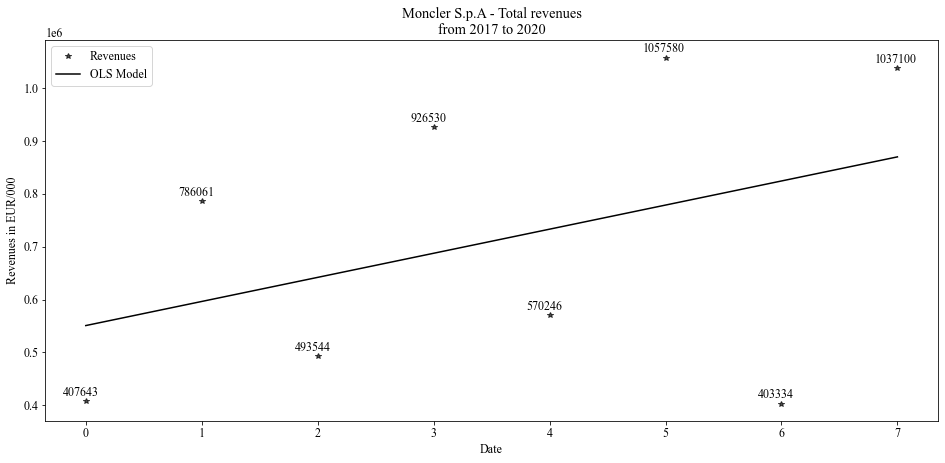

In [89]:
plt.subplots(1, figsize=(16, 7))
plt.plot(X_data, y_data, '*', c = 'black',alpha=0.7,label='Revenues')
plt.plot(X_data, OLS_intercept + OLS_slope * X_data, c = 'black',label='OLS Model')

for i, v in enumerate(df['revenues']):
    plt.text(i -0.2, v + 9999, str(v))
    
plt.title('Moncler S.p.A - Total revenues\nfrom 2017 to 2020');plt.ylabel('Revenues in EUR/000');plt.xlabel('Date')
plt.legend()
plt.show()

## ~ Summer ~

OLS is one the easiest method to compute historical figures in order to create the future predictions. Holt-Winters exponential smoothing should have been a better method to forecast a time serie with a clear trend and seasonal variations.

Each year, Moncler is publishing H1 results on June 30, and FY results at December 31st. H1 reports give us a great prediction for the full year. We can see a seasonality and a growing trend but the results of the beginning of the year are always lower. 
With both experience in retail and wholesale, I am aware that **sales are heavily link to weather** and **Autumn/Winter collections are bringing larger revenue streams** due to garments at higher price points (and higher margin). 

The OLS method might be too simple. If the weather and seasonality are important key factors. 
Let’s have a look at Facebook’s Prophet. 

### Facebook's Prophet

In [51]:
from fbprophet import Prophet

In [52]:
df2 = df

In [53]:
df2 = df.drop(['days'], axis=1)
df2.columns = ['ds','y']

In [54]:
model = Prophet(
    growth='linear',
    interval_width=0.95,
    seasonality_mode='multiplicative',
    daily_seasonality=False,
    weekly_seasonality=False,
)

In [55]:
model.add_seasonality(name='semi-annual',period=182, fourier_order=5)

In [56]:
model.fit(df2)

INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


In [57]:
future_pd = model.make_future_dataframe(periods=1,freq='Y',include_history=True)

In [58]:
forecast_pd = model.predict(future_pd)

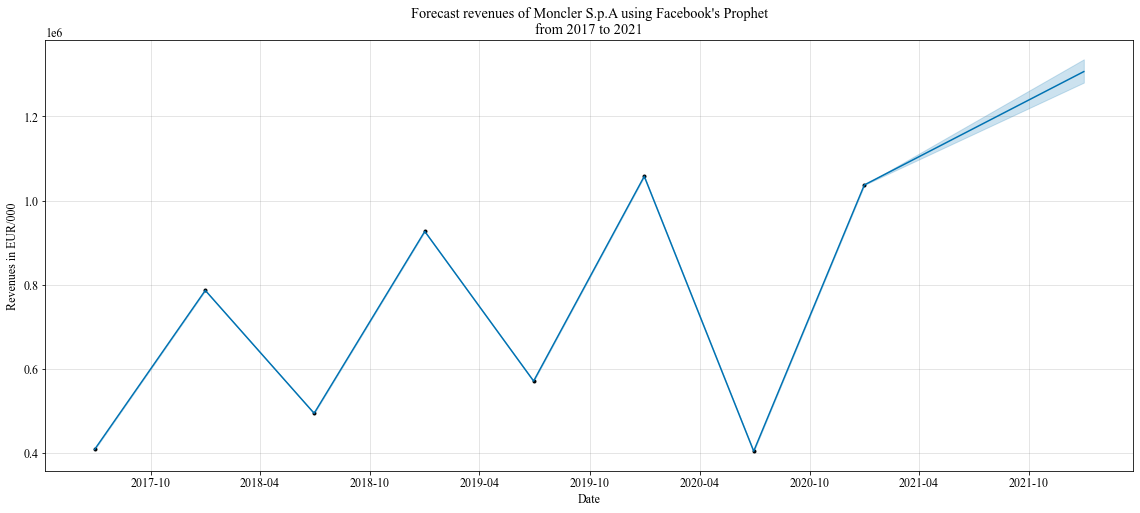

In [62]:
predict_fig = model.plot(forecast_pd, xlabel='Date', ylabel='Revenues',figsize=(16, 7))
plt.title("Forecast revenues of Moncler S.p.A using Facebook's Prophet\nfrom 2017 to 2021");plt.ylabel('Revenues in EUR/000');
plt.show() 

Time series can be often difficult to handle. **Facebook’s Prophet** is extremely intuitive. The name of variables “DS” and “Y” are standardized for simplicity. Date format is properly formatted in the visualization. The developing team smartly designed Prophet by integrating **lunar calendar**, or **popular sport events** that are relevant in marketing. Prophet might have been design for huge datasets. The prediction with linear growth at 90 days seems to be a lost maybe due to the lack of data. 



## ~ Autumn ~

Probabilistic programming is offering a great alternative to forecast time series from a small dataset using a knowledge experience. The Bayesian Linear Regression is not drawing the most accurate line according to values but rather using their probabilities of distribution. The Bayesian approach give us freedom to optimize parameters and incorporate some domain knowledge.  

If we have a normal Gaussian Distribution:

$$ y \sim N(\beta^{T}X, \sigma^{2} I) $$

Then we will have a Bayesian Linear Regression as follow:

$$ p(\beta | y, X) = \frac{p(y,X| \beta) p(\beta)}{p(y,X)} $$ 


In more simple words:

$$ Posterior = \frac{Likelihood * Prior}{Normalization} $$ 


Where we should incorporate domain knowledge in "Prior" and it will give us "Likelihood" as a probability of risk.

### Bayesian approach with PyStan

In [30]:
import pystan

In [31]:
df3 = pd.read_csv("Moncler-Income3.csv",sep=";")

In [32]:
x = df3['days'].to_numpy()
y = df3['revenues'].to_numpy()

In [33]:
data = {'N': np.size(x), 'x':x, 'y':y}

In [35]:
model_code = """
data {
    int<lower=0> N; // Number of Data - 8
    vector[N] x; // Input - Days
    vector[N] y; // Output - Revenues 
}
parameters {
    real alpha; // Slope
    real beta; // Intercept
    real<lower=0> sigma; // Noise 
}
model {
    y ~ normal(alpha + beta * x, sigma); // Bayesian Linear with noise
}
"""

model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f56eed6f05d6f0a5b715c38c0b464bc6 NOW.


In [36]:
fit = model.sampling(data=data)

In [43]:
print(fit)

Inference for Stan model: anon_model_f56eed6f05d6f0a5b715c38c0b464bc6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  5.1e5   1.1e4  3.2e5 -1.3e5  3.3e5  5.0e5  6.8e5  1.2e6    798   1.01
beta  252.55    11.9 344.17 -476.5  62.89 258.18 444.51  956.8    836    1.0
sigma  3.6e5  5620.5  1.6e5  1.8e5  2.6e5  3.2e5  4.1e5  8.0e5    842   1.02
lp__  -92.59    0.08   1.74 -97.22  -93.3 -92.11 -91.38  -90.7    483   1.02

Samples were drawn using NUTS at Tue Mar 16 18:23:08 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


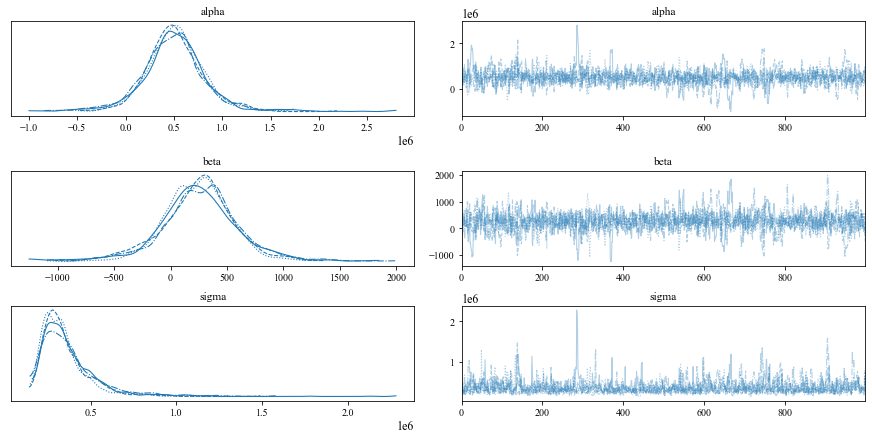

In [44]:
az.plot_trace(fit);

In [84]:
params = fit.extract()
alpha = np.mean(params['alpha'])
beta = np.mean(params['beta'])
sigma = np.mean(params['sigma'])
noise = np.min(params['sigma'])

In [48]:
yCI=np.zeros((0,2)) #Quantile to create limitations
for xi in xr:
    yCI = np.vstack((yCI,np.quantile(params['beta']*xi + params['alpha'], q=[0.05,0.95])))

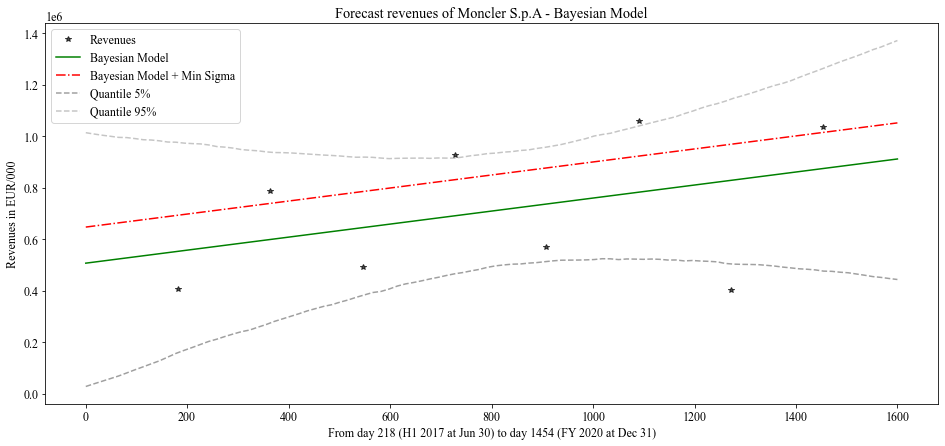

In [90]:
plt.subplots(1, figsize=(16, 7))

xr=np.linspace(0,1600,100)
plt.plot(x,y,'*',c='black',alpha=0.7,label='Revenues')
plt.plot(xr, beta*xr + alpha, c='green',label='Bayesian Model')  
plt.plot(xr, beta*xr + alpha + noise,c='red',linestyle='-.',label='Bayesian Model + Min Sigma')
plt.plot(xr, yCI[:,0], c='grey',linestyle='--',alpha=0.75,label='Quantile 5%')
plt.plot(xr, yCI[:,1], c='grey',linestyle='--',alpha=0.45,label='Quantile 95%')

plt.title('Forecast revenues of Moncler S.p.A - Bayesian Model'); plt.xlabel('From day 218 (H1 2017 at Jun 30) to day 1454 (FY 2020 at Dec 31)'); plt.ylabel('Revenues in EUR/000')
plt.legend()
plt.show()

Even if I didn't go fully into the Bayesian workflow. And this Bayesian linear regression is pretty basic. Bayesian approach is a powerful tool with only few data and a domain expertise. For example, the results of H1 2020 (1454) was the lowest point for Moncler due to the spread of SARS-Cov2. The Italian company will certainly grow faster for H1 2021. If we used the Holt-Winters exponential smoothing would have automatically giving a lot of weight to that last value. Therefore, it would have been interesting to give maybe a Half-Cauchy or BiNomial to sigma for our Bayesian approach.


## ~ Winter ~

It can be interesting to forecast total revenues with a **hierachical model** according to:

- Financial results by regions
- Number of stores by geography
- Digital performance on social media platforms
- Weather forecast

$$ { Sales (China) } \sim N(\mu{Sales}, \sigma^{2}) $$

$$ { \mu{Sales} = \alpha ({Stores})+ \beta{WeChat(微信)}+ \beta {Weibo(微博)}+ \beta {Douyin(抖音) } } $$

$$ { \beta Time ^ {t} + \sum_j {\beta { Week Day_j}} + Weather Index } $$




This hierarchical model brings me not to an estimation, but to a second question. :)

From an ESG perspective, should investors view Moncler S.p.A as a long-term investment when most of revenues are coming from coats? One thing is for sure, the Italian luxury group doesn’t seem to be afraid of global warming.

Thank you for reading!

Please feel free to contact me if you have any questions.

**Akim Mousterou**

***

**Disclaimer**: *None of the content published on this notebook constitutes a recommendation that any particular security, portfolio of securities, transaction, or investment strategy is suitable for any specific person. None of the information providers or their affiliates will advise you personally concerning the nature, potential, value, or suitability of any particular security, portfolio of securities, transaction, investment strategy, or other matter.*